<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [2315]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"


In [2316]:
import requests
import bs4
from bs4 import BeautifulSoup
import pprint
import re
import numpy as np
import pandas as pd
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from time import time, sleep

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [2317]:
# Extract the job title
def extract_title(jobs):
    titles = []
    for x in jobs:
        title = x.find(class_ = 'jobTitle').text
        titles.append((" ").join(re.findall(r'[^\s\\]+', title)))
    return titles

In [2318]:
# Extract the raw location (all info in the location string)
def extract_location(jobs):
    location = []
    for x in jobs:
        loc = x.find(class_ = 'companyLocation').text
        location.append((" ").join(re.findall(r'[^\s\\]+', loc)))
    return location

In [2319]:
# extract more precise location/ main location
# e.g. for 'remote in Albany, NY' this would give Albany
def extract_cities(jobs):
    cities = []
    for x in jobs:
        loc = x.find(class_ = 'companyLocation').text
        try:
            city = re.search(r'(?<= in )(.*)(?=,)|(?<= in )(.*)(?=\+)|(?<= in )(.*)', loc)
            cities.append(city.group())
        except:
            try:
                city = re.search(r'^(.*)(?=,)|^(.*)(?=\+)', loc)
                cities.append(city.group())
            except:
                cities.append(loc)

In [2320]:
# extract state
state_dict = us_state_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA",
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA",
    "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT",
    "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia": "DC",
    "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI",
}
state_list = list(state_dict.keys())


def extract_state(jobs):
    state = []
    for x in jobs:
        loc = x.find(class_ = 'companyLocation').text
        try:
            pattern = re.compile(r"(?=("+'|'.join(state_dict.values())+r"))")
            state_code = re.findall(pattern, loc)
            if len(state_code):
                state.append(''.join(state_code))
            else:
                pattern2 = re.compile(r"(?=("+'|'.join(state_dict.keys())+r"))", re.IGNORECASE)
                state_name = re.findall(pattern2, loc)
                if len(state_name):
                    state.append(state_dict[''.join(state_name)])  
                else:
                    state.append('none')
        except: 
                state.append('none') 
    return state

In [2321]:
# extract zipcode
def zipcode(jobs):        
    zipcode = []
    for x in jobs:
        try:
            address = x.find(class_ = 'companyLocation').text
            pattern = re.compile(r'\d{5}[-/ ]\d{4}|\d{5}|[A-Z]\d[A-Z][-/ ]\d[A-Z]\d')
            zipc = re.findall(pattern, address)
            if len(zipc): 
                zipcode.append("".join(zipc))
            else:
                zipcode.append('none')
        except:
            zipcode.append('none')

    return zipcode

In [2322]:
# Extract company
def extract_company(jobs):
    companies = []
    for x in jobs:
        try:
            company = x.find('span', class_ = 'companyName').text
            companies.append((" ").join(re.findall(r'[^\s\\]+', company)))  
        except:
            companies.append('none')
    return companies

In [2323]:
# Extract salary
def extract_salary(jobs):
    salary = []
    timeframe = []
    for x in jobs:
        try:
            sal = x.find(class_ = 'salary-snippet-container').text.strip()
            salary.append((" ").join(re.findall(r'[^\s\\$£]+', sal)))
        except:
            salary.append('none')
    return salary

In [2324]:
# calculate mean salary
def extract_salary_mean(jobs):
    mean_salary = []
    for x in jobs:
        try:
            sal = x.find(class_ = 'salary-snippet-container').text.strip()
            num = re.findall(r'\d+[,\.]?\d+K?', sal)
            cleaned_sal = []
            for x in num:
                x = x.replace(",","")
                try:
                    val = float(x)
                    cleaned_sal.append(val)
                except:
                    x=x.replace("K","")
                    val = float(x)*1000
                    cleaned_sal.append(val)
            mean_salary.append(np.mean(cleaned_sal)) 
        except:
            mean_salary.append('none') 

    return mean_salary                 

In [2325]:
# Extract estimated salary (added by indeed as a prediction)
def extract_estimate_salary(jobs):
    salary = []
    timeframe = []
    for x in jobs:
        try:
            sal = x.find(class_ = 'estimated-salary').text.strip()
            salary.append((" ").join(re.findall(r'[^\s\\$£]+', sal)))
        except:
            salary.append('none')
    return salary

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [2326]:
url = f"http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=5000"

In [2327]:
# First scrape
# max_results_per_city = 1000

# driver = webdriver.Chrome(ChromeDriverManager().install())

# results = pd.DataFrame(columns = ['title', 'company','raw_location',  'city',
#                                   'state','zipcode', 'city_search', 'raw_salary', 'mean_sal']) 

# for city in set(['Atlanta', 'Austin', 'Boston', 'Chicago', 'Colorado',
#            'Dallas', 'Denver', 'Detroit', 'Houston', 'Los+Angeles',
#            'Menlo+Park', 'Miami', 'New+York', 'Palo+Alto', 'Philadelphia',
#            'Phoenix', 'Pittsburgh', 'Portland', 'San+Diego', 'San+Francisco',
#            'San+Jose', 'Seattle', 'Washington', 'Ontario', 'Florida',
#            'Minneapolis', 'St+Louis', 'Baltimore', 'Orlando', 'Kansas',
#            'Nashville', 'Oklahoma', 'New+Orleans']):
#     for role in set(['data+scientist','data+analyst']):
#         for start in range(0, max_results_per_city, 10):
#             url = f"http://www.indeed.com/jobs?q={role}+%2420%2C000&l={city}&start={start}"
#             driver.get(url)
#             html = driver.page_source
#             soup = BeautifulSoup(html, 'html.parser')
#             jobs = soup.find_all('td', class_ = 'resultContent')

#             data = {'title' : extract_title(jobs), 
#                     'company' : extract_company(jobs), 
#                     'raw_location' : extract_location(jobs),
#                     'city' : extract_cities(jobs),
#                     'state' : extract_state(jobs),
#                     'zipcode' : zipcode(jobs),
#                     'city_search' : city,
#                     'raw_salary' : extract_salary(jobs), 
#                     'mean_sal' : extract_salary_mean(jobs), 
#                     'estimated_sal' : extract_estimate_salary(jobs)}

#             results_df = pd.DataFrame(data)

#             results = pd.concat([results, results_df], ignore_index = True)
#             sleep(3)
# driver.quit()
# results.to_csv('first_scrape')
# results

In [2328]:
# Second scrape - increase number of job roles, changed code for state and city extraction
# had to stop because it was taking too long - did not use these results

# max_results_per_city = 1000

# driver = webdriver.Chrome(ChromeDriverManager().install())

# results = pd.DataFrame(columns = ['title', 'company','raw_location',  'city',
#                                   'state','zipcode', 'city_search','job_search', 'raw_salary', 'mean_sal']) 

# for city in set(['Atlanta', 'Austin', 'Boston', 'Chicago', 'Colorado',
#            'Dallas', 'Denver', 'Detroit', 'Houston', 'Los+Angeles',
#            'Menlo+Park', 'Miami', 'New+York', 'Palo+Alto', 'Philadelphia',
#            'Phoenix', 'Pittsburgh', 'Portland', 'San+Diego', 'San+Francisco',
#            'San+Jose', 'Seattle', 'Washington', 'Ontario', 'Florida',
#            'Minneapolis', 'St+Louis', 'Baltimore', 'Orlando', 'Kansas',
#            'Nashville', 'Oklahoma', 'New+Orleans']):
#     for role in set(['data+scientist','data+analyst','business+intelligence','machine+learning', 
#                      'data+engineer', 'statistician','data+consultant', 'cloud+engineer', 
#                      'natural+language+processing','quantitative+researcher']):
#         for start in range(0, max_results_per_city, 10):
#             url = f"http://www.indeed.com/jobs?q={role}+%2420%2C000&l={city}&start={start}"
#             driver.get(url)
#             html = driver.page_source
#             soup = BeautifulSoup(html, 'html.parser')
#             jobs = soup.find_all('td', class_ = 'resultContent')

#             data = {'title' : extract_title(jobs), 
#                     'company' : extract_company(jobs), 
#                     'raw_location' : extract_location(jobs),
#                     'city' : extract_cities(jobs),
#                     'state' : extract_state(jobs),
#                     'zipcode' : zipcode(jobs),
#                     'city_search' : city,
#                     'job_search' : role,
#                     'raw_salary' : extract_salary(jobs), 
#                     'mean_sal' : extract_salary_mean(jobs), 
#                     'estimated_sal' : extract_estimate_salary(jobs)}

#             results_df = pd.DataFrame(data)

#             results = pd.concat([results, results_df], ignore_index = True)
#             sleep(3)
# driver.quit()
# results.to_csv('second_scrape')
# results

In [2329]:
# Scrape 3: look at more job roles with lower number of pages

# max_results_per_city = 500

# driver = webdriver.Chrome(ChromeDriverManager().install())

# results = pd.DataFrame(columns = ['title', 'company','raw_location',  'city',
#                                   'state','zipcode', 'city_search','job_search', 'raw_salary', 'mean_sal']) 

# for city in ['Atlanta', 'Austin', 'Boston', 'Chicago', 'Colorado',
#            'Dallas', 'Denver', 'Detroit', 'Houston', 'Los+Angeles',
#            'Menlo+Park', 'Miami', 'New+York', 'Palo+Alto', 'Philadelphia',
#            'Phoenix', 'Pittsburgh', 'Portland', 'San+Diego', 'San+Francisco',
#            'San+Jose', 'Seattle', 'Washington', 'Ontario', 'Florida',
#            'Minneapolis', 'St+Louis', 'Baltimore', 'Orlando', 'Kansas',
#            'Nashville', 'Oklahoma', 'New+Orleans', 'Las+Vegas']:
#     for role in set(['data+scientist','data+analyst','machine+learning', 
#                      'data+engineer','cloud+engineer', 
#                      'natural+language+processing']):
#         for start in range(0, max_results_per_city, 10):
#             url = f"http://www.indeed.com/jobs?q={role}+%2420%2C000&l={city}&start={start}"
#             driver.get(url)
#             html = driver.page_source
#             soup = BeautifulSoup(html, 'html.parser')
#             jobs = soup.find_all('td', class_ = 'resultContent')

#             data = {'title' : extract_title(jobs), 
#                     'company' : extract_company(jobs), 
#                     'raw_location' : extract_location(jobs),
#                     'city' : extract_cities(jobs),
#                     'state' : extract_state(jobs),
#                     'zipcode' : zipcode(jobs),
#                     'city_search' : city,
#                     'job_search' : role,
#                     'raw_salary' : extract_salary(jobs), 
#                     'mean_sal' : extract_salary_mean(jobs), 
#                     'estimated_sal' : extract_estimate_salary(jobs)}

#             results_df = pd.DataFrame(data)

#             results = pd.concat([results, results_df], ignore_index = True)
#             sleep(3)
# driver.quit()
# results.to_csv('third_scrape')
# results

### Import data and remove duplicates

In [2518]:
# load data from first scrape
job_results = pd.read_csv('first_scrape')
job_results.head()

,Unnamed: 0,title,company,raw_location,city,state,zipcode,city_search,raw_salary,mean_sal,estimated_sal
0,0,Data Science Analyst,Farallon Capital Management,"San Francisco, CA 94111 (Financial District/So...",San Francisco,CA,94111,San+Francisco,none,none,Estimated 75.9K - 96.2K a year
1,1,Data Analyst/Data Scientist,Tek Ninjas,"Oakland, CA 94601 (Harrington area)",Oakland,CA,94601,San+Francisco,none,none,Estimated 76.1K - 96.3K a year
2,2,Research Data Analyst,University of California San Francisco,"San Francisco, CA 94143 (Inner Sunset area)",San Francisco,CA,94143,San+Francisco,none,none,none
3,3,Data Analyst,NCIRE,"San Francisco, CA 94121 (Outer Richmond area)",San Francisco,CA,94121,San+Francisco,none,none,Estimated 86.9K - 110K a year
4,4,"Strategy & Planning Analyst, New Verticals",Uber,"San Francisco, CA 94103 (South of Market area)",San Francisco,CA,94103,San+Francisco,none,none,Estimated 67.1K - 85K a year


In [2519]:
# load data from third scrape
job_results2 = pd.read_csv('third_scrape')
job_results2.head()

,Unnamed: 0,title,company,raw_location,city,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal
0,0,Data Engineer,Tek Ninjas,"Atlanta, GA 30302 (Five Points area)",Atlanta,GA,30302,Atlanta,data+engineer,none,none,87.2K - 110K a year (Estimated)
1,1,Data Engineer,Delta,"Atlanta, GA",Atlanta,GA,none,Atlanta,data+engineer,none,none,86.2K - 109K a year (Estimated)
2,2,Data Warehouse Engineer,Children's Healthcare of Atlanta,"Brookhaven, GA 30329",Brookhaven,GA,30329,Atlanta,data+engineer,none,none,94.3K - 119K a year (Estimated)
3,3,Azure Data engineer,Cognizant,"Remote in Atlanta, GA 30317",Atlanta,GA,30317,Atlanta,data+engineer,"100,000 - 150,000 a year",125000.0,none
4,4,Data Engineer,New Relic,"Remote in Atlanta, GA",Atlanta,GA,none,Atlanta,data+engineer,"102,000 - 128,000 a year",115000.0,none


In [2520]:
# concatentate the csvs from the two scrapes
job_results = pd.concat([job_results2, job_results])
job_results.head()

,Unnamed: 0,title,company,raw_location,city,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal
0,0,Data Engineer,Tek Ninjas,"Atlanta, GA 30302 (Five Points area)",Atlanta,GA,30302,Atlanta,data+engineer,none,none,87.2K - 110K a year (Estimated)
1,1,Data Engineer,Delta,"Atlanta, GA",Atlanta,GA,none,Atlanta,data+engineer,none,none,86.2K - 109K a year (Estimated)
2,2,Data Warehouse Engineer,Children's Healthcare of Atlanta,"Brookhaven, GA 30329",Brookhaven,GA,30329,Atlanta,data+engineer,none,none,94.3K - 119K a year (Estimated)
3,3,Azure Data engineer,Cognizant,"Remote in Atlanta, GA 30317",Atlanta,GA,30317,Atlanta,data+engineer,"100,000 - 150,000 a year",125000.0,none
4,4,Data Engineer,New Relic,"Remote in Atlanta, GA",Atlanta,GA,none,Atlanta,data+engineer,"102,000 - 128,000 a year",115000.0,none


In [2521]:
# drop unnamed column
job_results.drop(columns = ['Unnamed: 0'], inplace = True)

In [2522]:
# drop duplicates
# only used columns where the code wasn't changed between scrapes (incorrectly extracted info will be cleaned later)
job_results.drop_duplicates(subset = ['title', 'company', 'raw_location', 'raw_salary','estimated_sal'], 
                           inplace = True)

In [2523]:
job_results.shape

(44649, 11)

In [2524]:
# check returned results per city search
job_results.groupby('city_search')['title'].count().sort_values(ascending = False)

city_search
New+York         3413
Boston           2932
Menlo+Park       2749
Chicago          2711
Dallas           2494
Atlanta          2222
Florida          2083
Los+Angeles      1970
San+Francisco    1919
Austin           1825
Seattle          1794
Baltimore        1628
Colorado         1582
Houston          1574
Philadelphia     1518
Minneapolis      1364
Phoenix          1302
San+Diego        1201
Detroit          1187
Pittsburgh        915
Miami             795
St+Louis          770
Portland          759
Nashville         699
Kansas            496
Ontario           411
Oklahoma          400
Las+Vegas         388
Washington        364
Orlando           329
Palo+Alto         252
Denver            216
San+Jose          212
New+Orleans       175
Name: title, dtype: int64

In [2525]:
# drop rows where the salary isn't available
job_results = job_results[job_results['raw_salary']!= 'none']

In [2526]:
# look at the df dimensions
job_results.shape

(9871, 11)

In [2527]:
# reset index (sequential index required for the next step)
job_results.reset_index(drop = True, inplace = True)

In [2528]:
# collect indices of rows where salary is by day, week or month
not_year = []
for i in range(len(job_results['raw_salary'])):
    if 'hour' in job_results['raw_salary'].iloc[i]:
        not_year.append(i)
    elif 'day' in job_results['raw_salary'].iloc[i]:
        not_year.append(i)
    elif 'week' in job_results['raw_salary'].iloc[i]:
        not_year.append(i)
    elif 'month' in job_results['raw_salary'].iloc[i]:
        not_year.append(i)       

In [2529]:
# drop rows where salary is by day, week or month
job_results.drop(index = not_year, inplace = True)

In [2530]:
# for the first scrape the location was extracted incorrectly in a handful of cases (if 'in in the name')
# in the next scrape function was adjusted. However, to clean data from the first scrape will rerun the updated function
# rename this column 'location' as sometimes the job ad is written with suburb, sometimes state etc. 

location = []
for x in job_results['raw_location']:
    try:
        city = re.search(r'(?<= in )(.*)(?=,)|(?<= in )(.*)(?=\+)|(?<= in )(.*)', x)
        location.append(city.group())
    except:
        try:
            city = re.search(r'^(.*)(?=,)|^(.*)(?=\+)', x)
            location.append(city.group())
        except:
            location.append(x)

In [2531]:
# insert the new location column
job_results.insert(4, 'location', location)
job_results.head()

,title,company,raw_location,city,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal
0,Azure Data engineer,Cognizant,"Remote in Atlanta, GA 30317",Atlanta,Atlanta,GA,30317,Atlanta,data+engineer,"100,000 - 150,000 a year",125000.0,none
1,Data Engineer,New Relic,"Remote in Atlanta, GA",Atlanta,Atlanta,GA,none,Atlanta,data+engineer,"102,000 - 128,000 a year",115000.0,none
2,Data Engineer,Emergent Software,"Remote in Atlanta, GA",Atlanta,Atlanta,GA,none,Atlanta,data+engineer,"90,000 - 110,000 a year",100000.0,none
3,Staff Software Engineer - Data Science (Remote),Home Depot / THD,"Remote in Atlanta, GA 30301",Atlanta,Atlanta,GA,30301,Atlanta,data+engineer,"190,000 a year",190000.0,none
4,Data Engineer,IFG Companies,"Remote in Alpharetta, GA 30005",Alpharetta,Alpharetta,GA,30005,Atlanta,data+engineer,"110,000 - 140,000 a year",125000.0,none


In [2532]:
# Confirm the only discrepancy between city and location columns is when 'in' is in the location name 
job_results[job_results['city']!=job_results['location']]

,title,company,raw_location,city,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal
9515,Enterprise Tools Salesforce (Business Process ...,HII,"Mountain View, CA",View,Mountain View,CA,none,Menlo+Park,NaN,"93,474 - 160,000 a year",126737.0,none
9522,Spanish NLP Localization Engineer – Watson Orders,IBM,"Mountain View, CA 94035",View,Mountain View,CA,94035,Menlo+Park,NaN,"92,000 - 208,000 a year",150000.0,none
9574,IT Business Analyst II (Internal Hennepin Coun...,Hennepin County,"Hennepin County, MN",County,Hennepin County,MN,none,Minneapolis,NaN,"69,319 - 111,031 a year",90175.0,none


In [2533]:
# Drop the city column
job_results.drop(columns = 'city', inplace = True)

In [2534]:
# noticed that certain jobs are duplicated due to multiple locations. e.g.
job_results[job_results['title'] == 'Senior Backend Engineer (AI Startup)'].sort_values(by='location').head()

,title,company,raw_location,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal
773,Senior Backend Engineer (AI Startup),Recruiting From Scratch,"Remote in Andover, MA 01810",Andover,MA,01810,Boston,data+scientist,"120,000 - 180,000 a year",150000.0,none
79,Senior Backend Engineer (AI Startup),Recruiting From Scratch,"Remote in Atlanta, GA 30322",Atlanta,GA,30322,Atlanta,data+scientist,"120,000 - 180,000 a year",150000.0,none
424,Senior Backend Engineer (AI Startup),Recruiting From Scratch,"Remote in Austin, TX 73301",Austin,TX,73301,Austin,data+scientist,"120,000 - 180,000 a year",150000.0,none
8392,Senior Backend Engineer (AI Startup),Recruiting From Scratch,"Remote in Baltimore, MD 21201+1 location",Baltimore,MD,21201,Baltimore,data+scientist,"120,000 - 180,000 a year",150000.0,none
9801,Senior Backend Engineer (AI Startup),Recruiting From Scratch,"Remote in Baltimore, MD 21201",Baltimore,MD,21201,Baltimore,NaN,"120,000 - 180,000 a year",150000.0,none


In [2535]:
# we want to keep the same posting if it's in a different city (as we are using location as a predictor)
# however it seems between the first and second scrape the location is different for some jobs in the same city:
job_results[(job_results['title'] == 'Senior Backend Engineer (AI Startup)')&(job_results['city_search'] == 'Baltimore')]

,title,company,raw_location,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal
8392,Senior Backend Engineer (AI Startup),Recruiting From Scratch,"Remote in Baltimore, MD 21201+1 location",Baltimore,MD,21201,Baltimore,data+scientist,"120,000 - 180,000 a year",150000.0,none
9801,Senior Backend Engineer (AI Startup),Recruiting From Scratch,"Remote in Baltimore, MD 21201",Baltimore,MD,21201,Baltimore,NaN,"120,000 - 180,000 a year",150000.0,none


In [2536]:
# as we have cleaned up location, we can now drop duplicates using location instead of raw_location
job_results.drop_duplicates(subset = ['title', 'company', 'location', 'raw_salary','estimated_sal'],
                            inplace = True)

In [2537]:
# check dimensions of dataset after final duplication deletion
job_results.shape

(8063, 11)

### Data cleaning

In [2538]:
# convert mean salary to a float
job_results['mean_sal'] = job_results['mean_sal'].astype(float)

In [2539]:
# check states have been correctly extracted
job_results.groupby('state')['city_search'].value_counts()

state  city_search  
AZ     Phoenix           247
CA     Los+Angeles       291
       Menlo+Park        259
       San+Francisco     216
       San+Diego         171
       Ontario            68
       Palo+Alto          24
       San+Jose           21
CO     Colorado         1037
       Denver            152
CT     New+York            1
DE     Philadelphia       19
FL     Florida           342
       Miami             129
       Orlando            29
GA     Atlanta           301
IL     Chicago           289
       St+Louis           16
IN     Chicago             2
KS     Kansas             88
LA     New+Orleans         9
MA     Boston            279
MAMI   Boston              1
MD     Baltimore         293
MI     Detroit           145
MN     Minneapolis       263
MO     St+Louis          142
NJ     Philadelphia       16
NV     Las+Vegas          91
NY     New+York         1439
OK     Oklahoma           71
OR     Portland          119
PA     Philadelphia      186
       Pittsburgh     

In [2540]:
# Clean up states
# Check result that says New York and state is Conneticut
job_results[job_results['state'] == 'CT']

,title,company,raw_location,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal
4671,Senior Data Scientist - Risk Model Governance ...,Cigna,"Remote in Hartford, CT 06152",Hartford,CT,06152,New+York,machine+learning,"108,200 - 180,400 a year",144300.0,none


In [2541]:
# check why philadelphia is in Delaware
job_results[job_results['state'] == 'DE'].head()
# the city search is not always giving a city exactly in that location (radius of search etc)
# this is also true for city search St louis = IL, Chicago = IN, Philadelphia = NJ
# also have St louis in Louisiana and Missouri

,title,company,raw_location,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal
5585,Software Engineer - Big data/AWS,"JPMorgan Chase Bank, N.A.","Wilmington, DE",Wilmington,DE,none,Philadelphia,data+engineer,"123,500 - 180,000 a year",151750.0,none
5586,Python/AWS - Big Data Engineer,"JPMorgan Chase Bank, N.A.","Wilmington, DE",Wilmington,DE,none,Philadelphia,data+engineer,"137,750 - 225,000 a year",181375.0,none
5609,Data Scientist Fellowship - 1 Year,Tech Impact,"Hybrid remote in Wilmington, DE 19801",Wilmington,DE,19801,Philadelphia,data+scientist,"70,000 a year",70000.0,none
5611,CCB_Data and Analytics- Data Scientist Analyst...,"JPMorgan Chase Bank, N.A.","Wilmington, DE",Wilmington,DE,none,Philadelphia,data+scientist,"123,500 - 195,000 a year",159250.0,none
5633,Quant Analytics Sr. Associate - Payments,"JPMorgan Chase Bank, N.A.","Wilmington, DE",Wilmington,DE,none,Philadelphia,machine+learning,"99,750 - 150,000 a year",124875.0,none


In [2542]:
# Check state MAMI
job_results[job_results['state']=='MAMI']

,title,company,raw_location,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal
781,K-12 Educational Technologist,MIT,"Cambridge, MA 02139 (MIT area)",Cambridge,MAMI,02139,Boston,machine+learning,"70,000 - 85,000 a year",77500.0,none


In [2543]:
# Change MAMI to MA
job_results['state'] = job_results['state'].replace('MAMI','MA')

In [2544]:
# Look at the number of unique locations pulled out
len(job_results['location'].unique())

646

In [2545]:
# Look at the locations with the highest counts
job_results['location'].value_counts().iloc[:20]

New York            1117
Denver               427
Atlanta              253
Chicago              223
Austin               215
San Francisco        207
Boston               173
Seattle              171
San Diego            162
Houston              160
Dallas               142
Los Angeles          138
Phoenix              133
Boulder              121
Colorado Springs     115
Philadelphia         109
St. Louis            105
Minneapolis          102
Baltimore            100
Pittsburgh            90
Name: location, dtype: int64

In [2546]:
# look at the number of zipcodes that are available vs not
print('Number of listings with no zipcode:', job_results[job_results['zipcode'] == 'none'].shape[0])
# look at how many unique values we have 
print('Number of unique zipcodes:', job_results['zipcode'][job_results['zipcode'] != 'none'].nunique())

Number of listings with no zipcode: 3149
Number of unique zipcodes: 1235


In [2547]:
# add if work is remote, hybrid or in the office
# We are making the assumption that if remote is not specified the job will be in the office
remote = []
for x in job_results['raw_location']:
    if re.search("[Hh]ybrid [Rr]emote", x):
        remote.append("hybrid")
    elif re.search("[Rr]emote", x):
        remote.append("remote")
    else:
        remote.append("office")  

In [2548]:
# Append this new column to the dataframe
job_results['remote'] = remote

In [2549]:
# look at the number of other locations that the job is posted in 
multiple_locations = []
for x in job_results['raw_location']:
    if re.search(r'\+\d locations?', x):
        multiple_locations.append(''.join(re.findall(r'\+(\d) locations?', x)))
    else:
        multiple_locations.append(0)

In [2550]:
# add the number of other locations as a column in the df
job_results['additional_locations'] = multiple_locations

In [2551]:
# Clean title column
# Change everything to lowercase - some job ads have been written in caps
job_results['title'] = job_results['title'].map(lambda x: x.lower())
job_results.head()    

,title,company,raw_location,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal,remote,additional_locations
0,azure data engineer,Cognizant,"Remote in Atlanta, GA 30317",Atlanta,GA,30317,Atlanta,data+engineer,"100,000 - 150,000 a year",125000.0,none,remote,0
1,data engineer,New Relic,"Remote in Atlanta, GA",Atlanta,GA,none,Atlanta,data+engineer,"102,000 - 128,000 a year",115000.0,none,remote,0
2,data engineer,Emergent Software,"Remote in Atlanta, GA",Atlanta,GA,none,Atlanta,data+engineer,"90,000 - 110,000 a year",100000.0,none,remote,0
3,staff software engineer - data science (remote),Home Depot / THD,"Remote in Atlanta, GA 30301",Atlanta,GA,30301,Atlanta,data+engineer,"190,000 a year",190000.0,none,remote,0
4,data engineer,IFG Companies,"Remote in Alpharetta, GA 30005",Alpharetta,GA,30005,Atlanta,data+engineer,"110,000 - 140,000 a year",125000.0,none,remote,0


In [2552]:
# would be useful to look at the occurence of the word senior - however this is sometimes written sr. or sr

# replace sr./sr with senior
job_results['title'] = job_results['title'].str.replace("sr[\.]?", "senior")
# replace jr./jr with junior
job_results['title'] = job_results['title'].str.replace("jr[\.]?", "junior")

/var/folders/3p/2gz_s0k92qz15tt88vjh0hl40000gn/T/ipykernel_996/1716820829.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/3p/2gz_s0k92qz15tt88vjh0hl40000gn/T/ipykernel_996/1716820829.py:6: FutureWarning:

The default value of regex will change from True to False in a future version.



In [2553]:
# noticed that some jobs are connected by an underscore. 
for x in job_results['title']:
    if '_' in x:
        print(x)

ic senior_sse_data engineer_retail media automation_fy22_atlanta, ga
ic senior_sse_data engineer_pyspark, airflow_3_atlanta, ga
ccb_data and analytics - applied ai lead
data & software engineer - delivery (19_2022)
senior data and software engineer (22_2022)
ccb_applied ai ml lead
production support engineer_devops
ccb_data and analytics - applied ai associate
ccb_data and analytics - awm - business analysis and reporting specialist
ccb_data and analytics- data scientist analyst expert


In [2554]:
# replace underscore with a space so that we can more can more easily read individual words
job_results['title'] = job_results['title'].str.replace("_", " ")

In [2555]:
job_results[job_results['title'] == 'ic senior sse data engineer pyspark, airflow 3 atlanta, ga']

,title,company,raw_location,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal,remote,additional_locations
36,"ic senior sse data engineer pyspark, airflow 3...",Ugam,"Atlanta, GA",Atlanta,GA,none,Atlanta,data+engineer,"100,000 - 130,000 a year",115000.0,none,office,0


In [2556]:
# job_results.reset_index(drop = True, inplace = True)

### EDA

In [2557]:
job_results.shape

(8063, 13)

In [2558]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2559]:
# Look at the salary distribution
job_results['mean_sal'].describe()

count      8063.000000
mean     123817.143929
std       44422.320088
min        2800.000000
25%       92500.000000
50%      118000.000000
75%      150000.000000
max      500000.000000
Name: mean_sal, dtype: float64

In [2560]:
# minimum of 2800 is much too low to be an annual salary - check this value
job_results[job_results['mean_sal'] == 2800]

,title,company,raw_location,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal,remote,additional_locations
5906,software engineering adjunct professor,University of Advancing Technology,"Tempe, AZ 85283",Tempe,AZ,85283,Phoenix,machine+learning,"Up to 2,800 per class",2800.0,none,office,0


In [2561]:
# drop this row
job_results = job_results[job_results['mean_sal'] != 2800]
job_results.shape

(8062, 13)

/Users/florascott/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



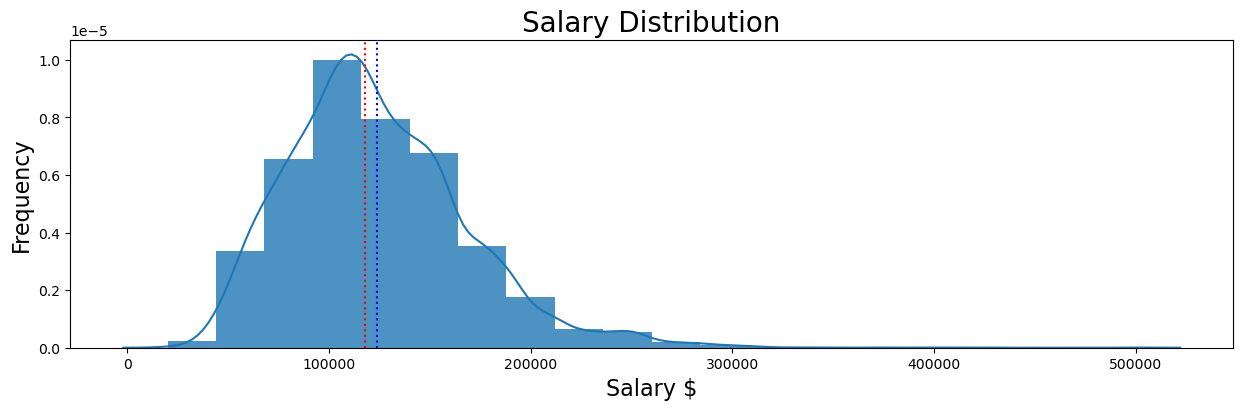

In [2562]:
# Plot the sale price distribution
fig, ax = plt.subplots(figsize=(15, 4))

sns.distplot(job_results['mean_sal'], bins=20, ax=ax, hist_kws={'alpha':0.8})
ax.set_xlabel('Salary $', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Salary Distribution', fontsize=20)
ax.axvline(x= job_results['mean_sal'].mean(), color='blue', linestyle='dotted')
ax.axvline(x= job_results['mean_sal'].median(), color='red', linestyle='dotted')
plt.show()

In [2563]:
# Save the mean, median, Q1 and Q3 as variables
mean_salary = job_results['mean_sal'].describe().loc['mean']
lower_quartile = job_results['mean_sal'].describe().loc['25%']
median_salary = job_results['mean_sal'].describe().loc['50%']
upper_quartile = job_results['mean_sal'].describe().loc['75%']

In [2564]:
# Create a df showing the value counts of each work environment
remote_jobs = pd.DataFrame({'counts' : job_results['remote'].value_counts()})
# Add the proportion of each working environment that is below the mean, Q1, Q2, Q3
remote_jobs['Prop < mean'] = job_results['remote'][job_results['mean_sal'] < mean_salary].value_counts()/remote_jobs['counts']
remote_jobs['Prop < Q1'] = job_results['remote'][job_results['mean_sal'] < lower_quartile].value_counts()/remote_jobs['counts']
remote_jobs['Prop < median'] = job_results['remote'][job_results['mean_sal'] < median_salary].value_counts()/remote_jobs['counts']
remote_jobs['Prop < Q3'] = job_results['remote'][job_results['mean_sal'] < upper_quartile].value_counts()/remote_jobs['counts']
remote_jobs

,counts,Prop < mean,Prop < Q1,Prop < median,Prop < Q3
office,5202,0.585544,0.282584,0.534987,0.772395
remote,2055,0.425304,0.133333,0.369830,0.615572
hybrid,805,0.664596,0.315528,0.603727,0.844720


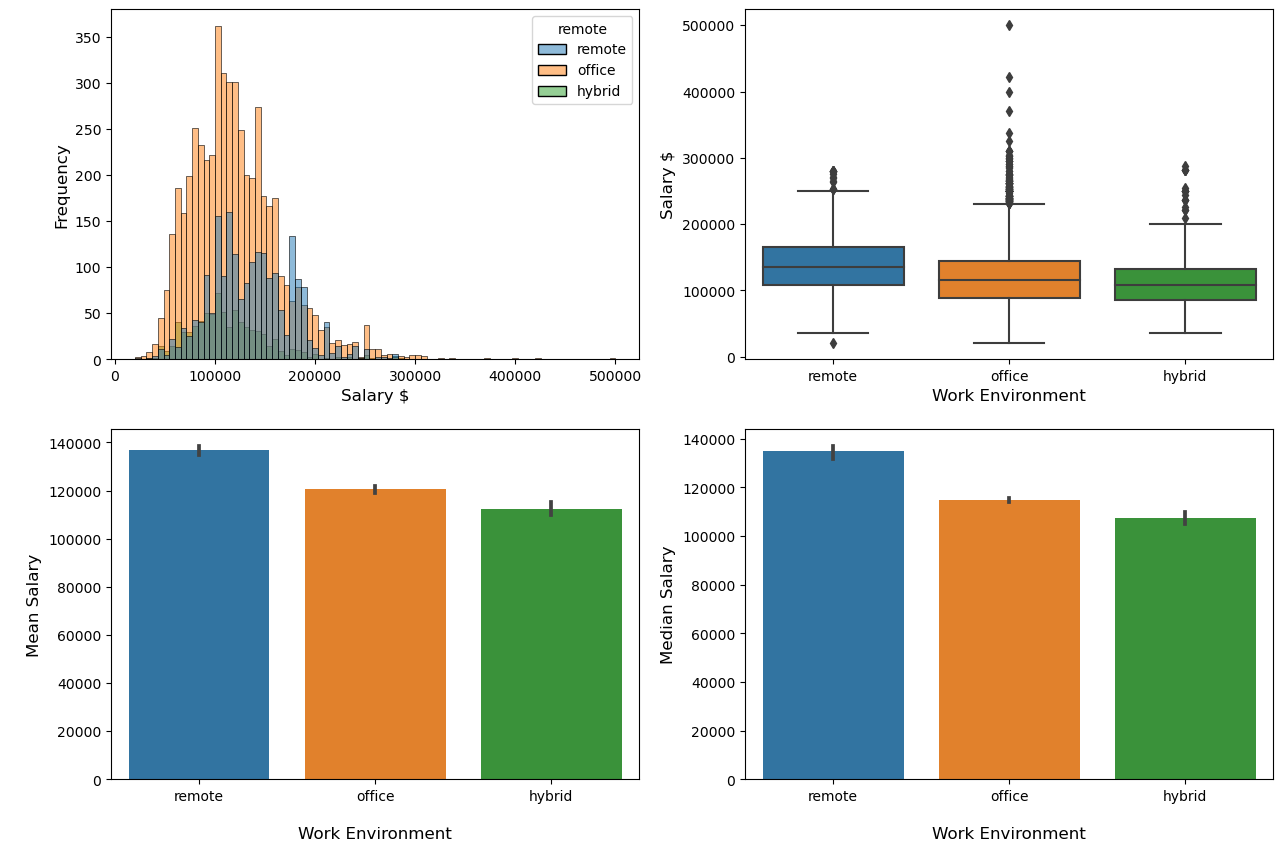

In [2565]:
# Look at the distribution per working environment (remote, hybrid, office)
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

sns.histplot(job_results, x = 'mean_sal', hue = 'remote', ax = ax[0,0])
ax[0,0].set_xlabel('Salary $', fontsize=12)
ax[0,0].set_ylabel('Frequency', fontsize=12)

sns.boxplot(data = job_results, x = 'remote', y = 'mean_sal', ax = ax[0,1])
ax[0,1].set_xlabel('Work Environment', fontsize=12)
ax[0,1].set_ylabel('Salary $', fontsize=12)

sns.barplot(data=job_results, x = 'remote', y = 'mean_sal', estimator = np.mean, ax = ax[1,0])
ax[1,0].set_xlabel('\nWork Environment', fontsize = 12)
ax[1,0].set_ylabel('\nMean Salary', fontsize = 12)

sns.barplot(data=job_results, x = 'remote', y = 'mean_sal', estimator = np.median, ax = ax[1,1])
ax[1,1].set_xlabel('\nWork Environment', fontsize = 12)
ax[1,1].set_ylabel('\nMedian Salary', fontsize = 12)

plt.show()

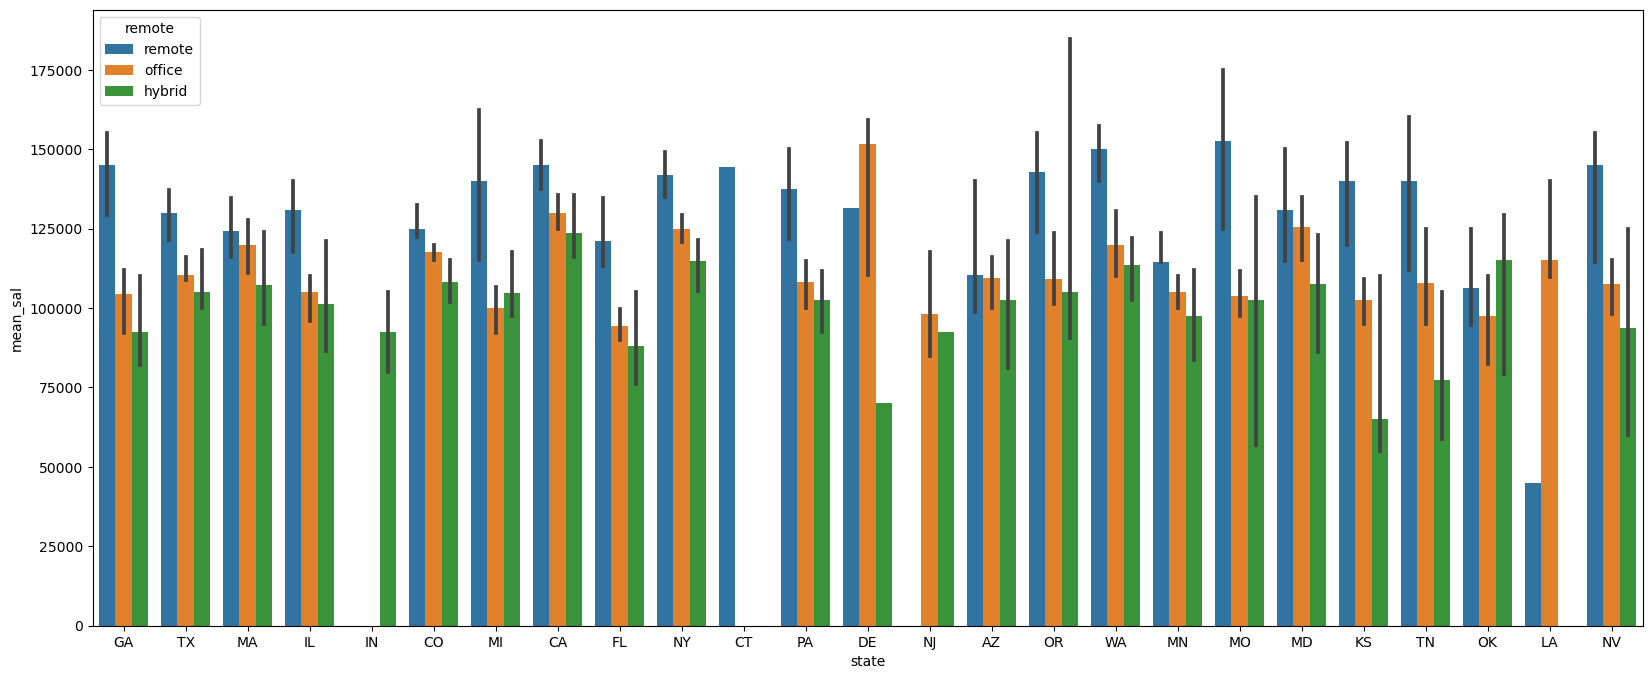

In [2566]:
# Plot the median salary per state for remote, hybrid and office jobs
fig, ax = plt.subplots(figsize = (20,8))
sns.barplot(data=job_results, x = 'state', y = 'mean_sal', hue = 'remote', estimator = np.median, ax=ax)
plt.show()

In [2567]:
# Create a df showing the value counts of state
state_jobs = pd.DataFrame({'counts' : job_results['state'].value_counts()})
# Add the proportion of jobs that have salaries lower than the mean salary of the whole dataset
state_jobs['Prop < mean'] = job_results['state'][job_results['mean_sal'] < mean_salary].value_counts()/ state_jobs['counts']
state_jobs.sort_values(by = 'Prop < mean')

,counts,Prop < mean
DE,19,0.315789
CA,1050,0.425714
NY,1439,0.471855
WA,365,0.482192
OR,119,0.504202
MD,293,0.505119
MA,280,0.550000
TN,110,0.563636
CO,1189,0.571068
GA,301,0.584718


In [2568]:
# Conneticut is showing NaN as there are no values below the mean. Drop rows for Conneticut & Indiana
# These do not have enough data to give a true representation when comparing salary per state

# Drop rows from main dataframe
job_results = job_results[(job_results['state'] != 'CT')& (job_results['state'] != 'IN')]

In [2569]:
# in terminal
# pip install plotly-express

In [2570]:
import plotly.express as px

In [2571]:
# create mean salary per US state
mean_sal_state = job_results.groupby('state')['mean_sal'].mean()
sal_state = pd.DataFrame({'state' : mean_sal_state.index, 'Mean Salary $' : mean_sal_state.values})
sal_state.sort_values(by = 'Mean Salary $', ascending = False).head(10)

,state,Mean Salary $
3,DE,137975.000000
1,CA,137073.053810
22,WA,132987.604110
16,NY,132898.252606
18,OR,130986.155462
10,MD,126071.317406
9,MA,124918.785714
5,GA,124258.624585
2,CO,120511.837679
20,TN,120457.177273


In [2572]:
# Plot the mean salary per state
fig = px.choropleth(sal_state,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Mean Salary $',
                    color_continuous_scale="Viridis_r", 
                    
                    )
fig.show()

In [2573]:
# create median salary per US state
median_sal_state = job_results.groupby('state')['mean_sal'].median()
med_state = pd.DataFrame({'state' : median_sal_state.index, 'Median Salary $' : median_sal_state.values})
med_state.sort_values(by = 'Median Salary $', ascending = False).head(10)

,state,Median Salary $
3,DE,151750.0
1,CA,134250.0
16,NY,127500.0
22,WA,125000.0
10,MD,122500.0
18,OR,120000.0
9,MA,120000.0
2,CO,118000.0
21,TX,115000.0
5,GA,115000.0


In [2574]:
# Plot the median salary per state
fig = px.choropleth(med_state,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Median Salary $',
                    color_continuous_scale="Viridis_r", 
                    
                    )
fig.show()

In [2575]:
# look at the most frequent locations and compare salaries
top_loc = job_results['location'].value_counts(ascending = False).iloc[:25]
top_loc

New York            1117
Denver               427
Atlanta              253
Chicago              223
Austin               215
San Francisco        207
Boston               173
Seattle              171
San Diego            162
Houston              160
Dallas               142
Los Angeles          138
Phoenix              133
Boulder              121
Colorado Springs     115
Philadelphia         109
St. Louis            105
Minneapolis          102
Baltimore            100
Pittsburgh            90
Portland              90
Miami                 88
Englewood             80
Broomfield            79
Nashville             76
Name: location, dtype: int64

In [2576]:
# filter df for just the jobs in these cities
top_df = job_results[job_results['location'].isin(top_loc.index)]

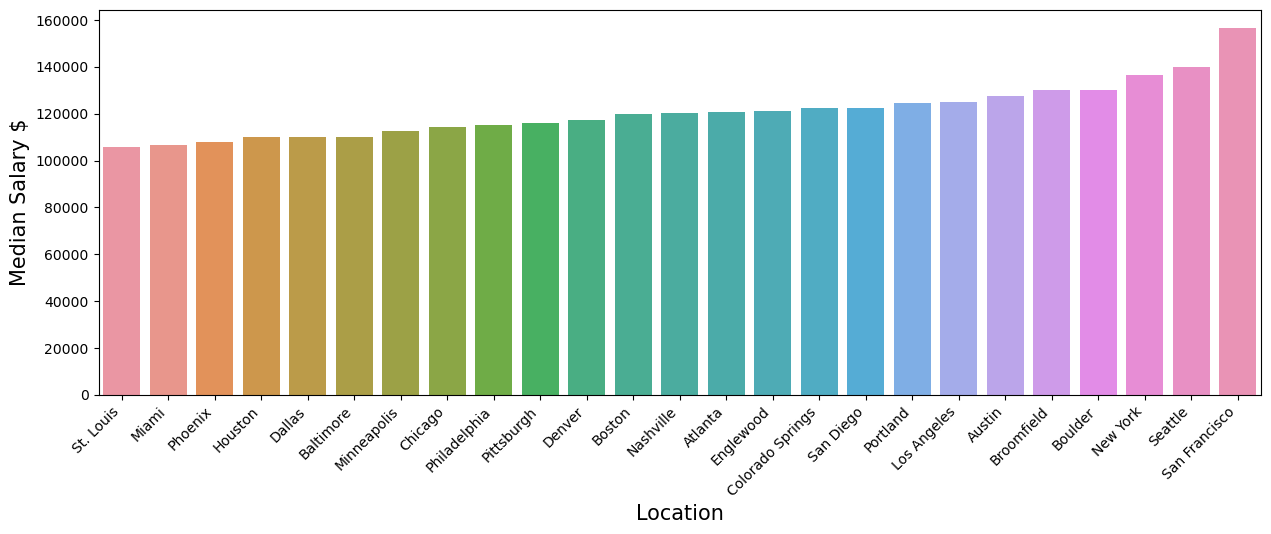

In [2577]:
# calculate the median salary per city and order then
med_city = top_df.groupby('location')['mean_sal'].median().sort_values()
# plot the median salary per city
fig, ax = plt.subplots(figsize = (15,5))

plt.xticks(rotation = 45, horizontalalignment='right')
sns.barplot(x = med_city.index, y = med_city.values, ax = ax)
ax.set_xlabel('Location', fontsize = 15)
ax.set_ylabel('Median Salary $', fontsize = 15)

plt.show()

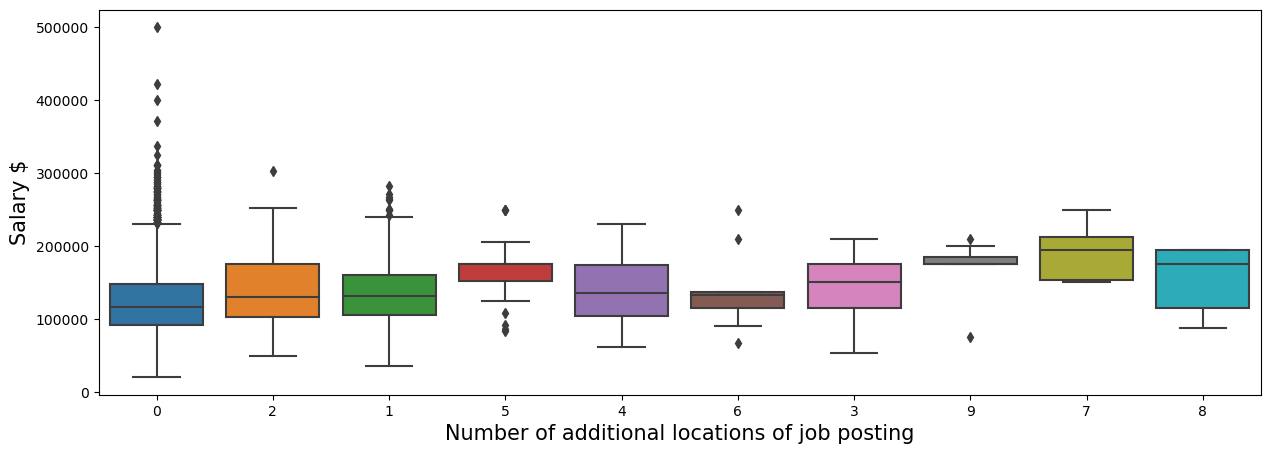

In [2578]:
# look at jobs with multiple locations (could be an indication of larger companies who have more money to spend)
fig, ax = plt.subplots(figsize = (15,5))

sns.boxplot(x = job_results['additional_locations'], y = job_results['mean_sal'])
ax.set_xlabel('Number of additional locations of job posting', fontsize = 15)
ax.set_ylabel('Salary $', fontsize = 15)
plt.show()

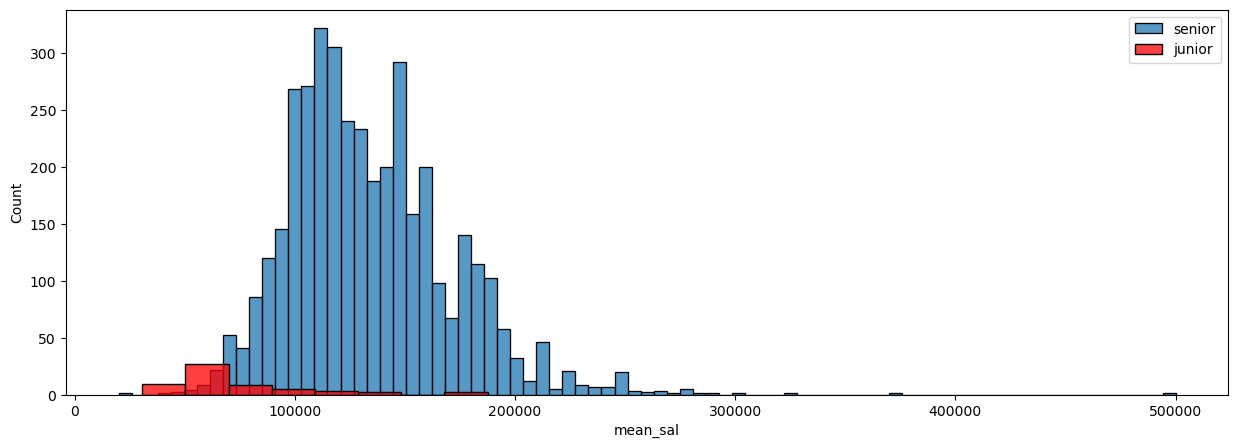

In [2579]:
# compare job salary for listings which contain the word 'senior' to those which contain 'junior'
senior = [i for i in range(len(job_results['title'])) if 'senior' in job_results['title'].iloc[i]]
junior = [i for i in range(len(job_results['title'])) if 'junior' in job_results['title'].iloc[i]]

fig, ax = plt.subplots(figsize = (15,5))

sns.histplot(job_results['mean_sal'].iloc[senior], ax = ax)
sns.histplot(job_results['mean_sal'].iloc[junior], bins = 8, color = 'r', ax = ax)

plt.legend(['senior','junior'])
plt.show()

In [2580]:
# compare how the mean salary changes with appearances of words such as senior and lead
senior = [i for i in range(len(job_results['title'])) if 'senior' in job_results['title'].iloc[i]]
lead = [i for i in range(len(job_results['title'])) if 'lead' in job_results['title'].iloc[i]]
chief = [i for i in range(len(job_results['title'])) if 'chief' in job_results['title'].iloc[i]]
head = [i for i in range(len(job_results['title'])) if 'head' in job_results['title'].iloc[i]]
manager = [i for i in range(len(job_results['title'])) if 'manager' in job_results['title'].iloc[i]]
director =[i for i in range(len(job_results['title'])) if 'director' in job_results['title'].iloc[i]]

seniority = pd.DataFrame({'count' : [job_results['mean_sal'].iloc[senior].shape[0],
                         job_results['mean_sal'].iloc[lead].shape[0], 
                         job_results['mean_sal'].iloc[chief].shape[0], 
                         job_results['mean_sal'].iloc[head].shape[0], 
                         job_results['mean_sal'].iloc[manager].shape[0],
                         job_results['mean_sal'].iloc[director].shape[0],
                         job_results['mean_sal'].shape[0]],
              'mean_sal' : [job_results['mean_sal'].iloc[senior].mean(), 
                            job_results['mean_sal'].iloc[lead].mean(), 
                            job_results['mean_sal'].iloc[chief].mean(), 
                            job_results['mean_sal'].iloc[head].mean(), 
                            job_results['mean_sal'].iloc[manager].mean(), 
                            job_results['mean_sal'].iloc[director].mean(),
                            job_results['mean_sal'].mean()]}, 
            index = ['senior', 'lead', 'chief', 'head', 'manager', 'director', 'all'])

seniority.sort_values(by = 'mean_sal', ascending = False)

,count,mean_sal
head,19,225286.789474
director,155,189654.612903
chief,21,160104.547619
manager,251,151083.097610
lead,326,140457.639571
senior,3918,133981.363578
all,8059,123837.390681


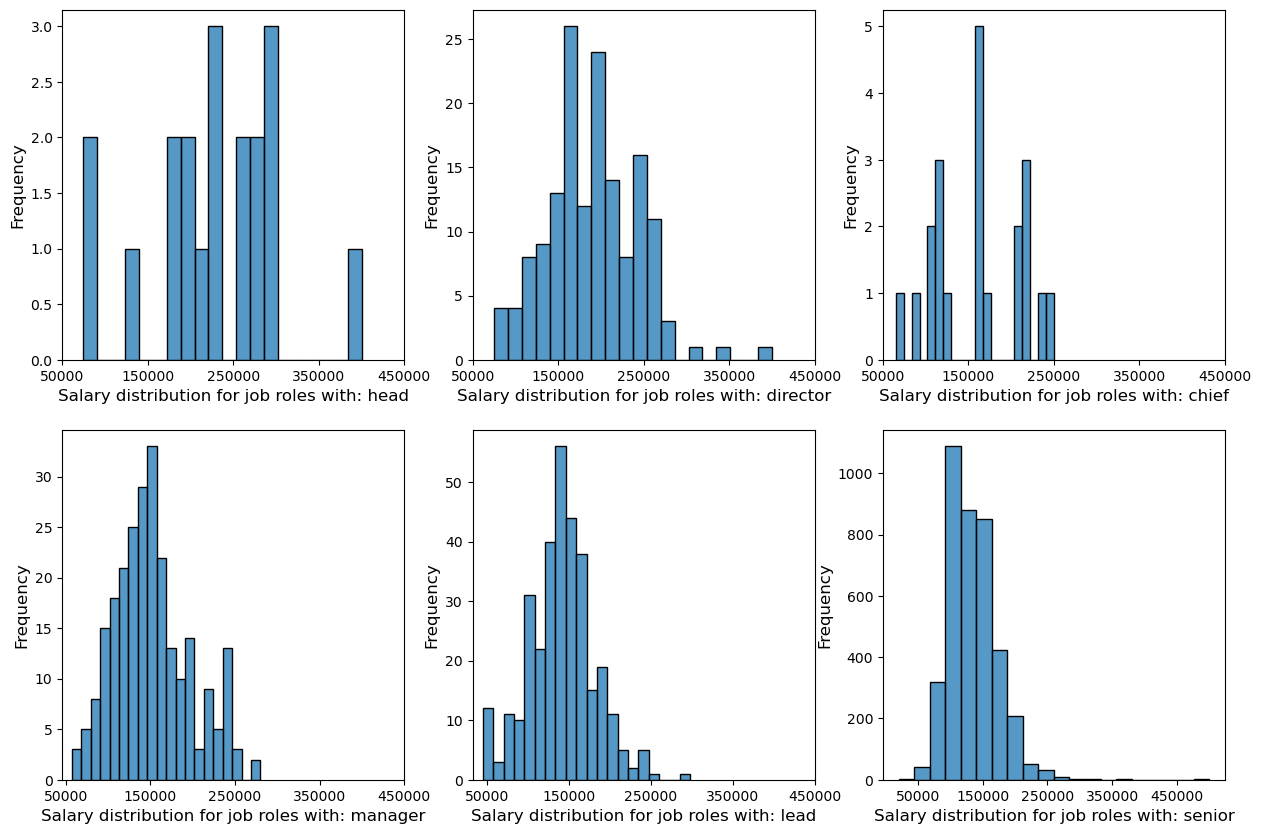

In [2581]:
# plot the distributions of salaries with the words above in on the same scale for comparison
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize = (15,10))

job_role = [head, director, chief, manager, lead, senior]
job = ['head', 'director', 'chief', 'manager', 'lead', 'senior']
axes = [ax0, ax1, ax2, ax3, ax4, ax5]

for x in range(len(job_role)):
    sns.histplot(job_results['mean_sal'].iloc[job_role[x]], bins = 20, ax = axes[x])
    axes[x].set_xlabel(f'Salary distribution for job roles with: {job[x]}', fontsize = 12)
    axes[x].set_ylabel('Frequency', fontsize = 12)
    axes[x].set_xticks(np.arange(50000, 500000, step=100000)) 
# fig.tight_layout()

In [2582]:
analyst = [i for i in range(len(job_results['title'])) if 'analyst' in job_results['title'].iloc[i]]
scientist = [i for i in range(len(job_results['title'])) if 'scientist' in job_results['title'].iloc[i]]
engineer = [i for i in range(len(job_results['title'])) if 'engineer' in job_results['title'].iloc[i]]
nlp = [i for i in range(len(job_results['title'])) if 'nlp' in job_results['title'].iloc[i]]
business = [i for i in range(len(job_results['title'])) if 'business' in job_results['title'].iloc[i]]
startup =[i for i in range(len(job_results['title'])) if 'startup' in job_results['title'].iloc[i]]


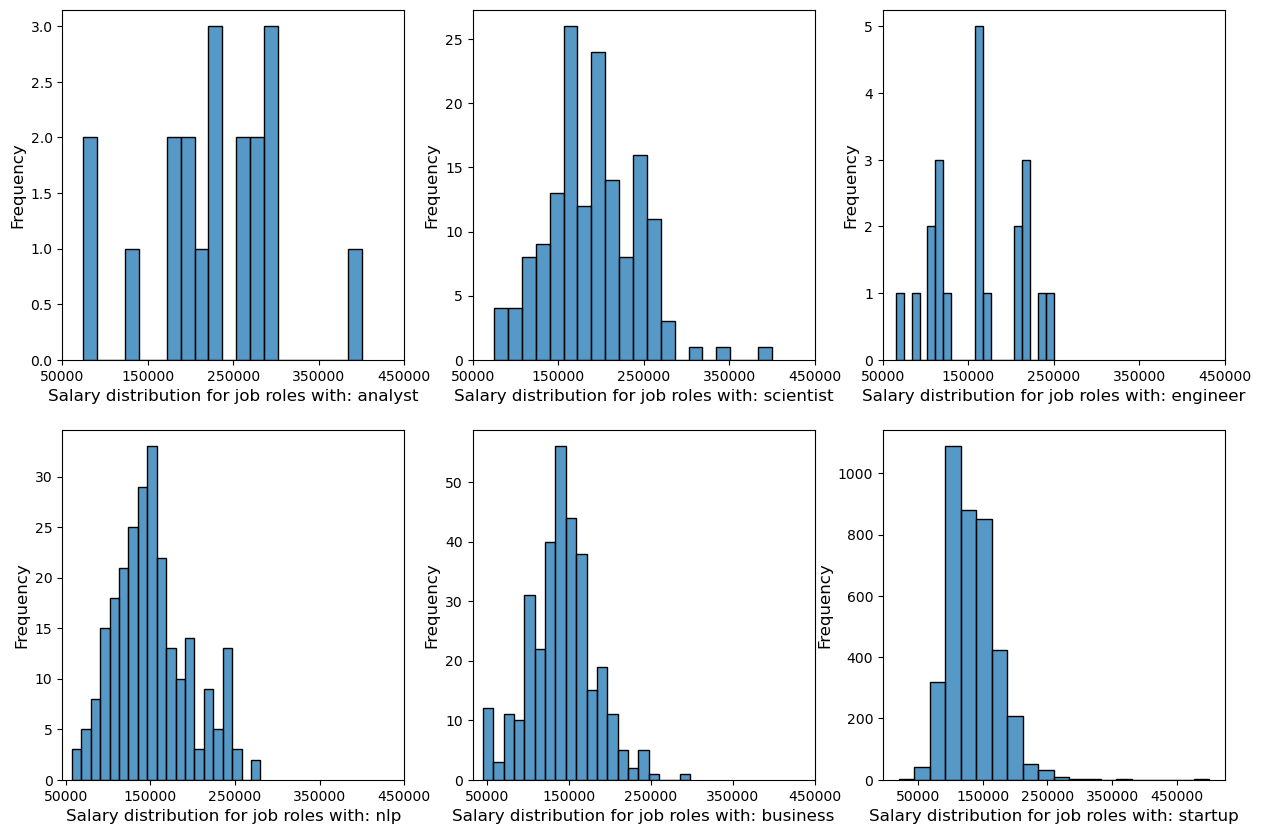

In [2583]:
# plot the distributions of salaries with the words above in on the same scale for comparison
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize = (15,10))

key_terms = [analyst, scientist, engineer, nlp, business, startup]
job = ['analyst', 'scientist', 'engineer', 'nlp', 'business', 'startup']
axes = [ax0, ax1, ax2, ax3, ax4, ax5]

for x in range(len(job_role)):
    sns.histplot(job_results['mean_sal'].iloc[job_role[x]], bins = 20, ax = axes[x])
    axes[x].set_xlabel(f'Salary distribution for job roles with: {job[x]}', fontsize = 12)
    axes[x].set_ylabel('Frequency', fontsize = 12)
    axes[x].set_xticks(np.arange(50000, 500000, step=100000)) 
# fig.tight_layout()

## Interesting takeaways from EDA
    
**Remote jobs**
Although we have made an assumption that unless specified as remote, jobs are fully in the office (very unlikely to be true in a post covid era), there are seemingly some very interesting trends in remote vs not remote.
1. Remote salaries seem be higher on average than those not specified as remote and the distribution is narrower. There are proportionally fewer remote jobs below the mean salary. We could hypothesise that for higher positions (and therefore higher salaries), companies are more willing to hire remotely, so as to attract the best candidate, not limited by those within a close proximity. Presumably this would make less sense for an entry level job. Additionally in an entry level job it could be more beneficial to be in the office with easier access to training / support


**Location**
1. The highest median salary is for Delaware. Although this should be taken with a pinch of salt, as we do not have many values for Delaware (in hindsight it would have been benefial to try and get a more distributed range of values per state), the city of Wilmington in Delaware is described as 'the corporate capital of America'.
2. Other states with high values are as expected e.g. CA, NY etc.
3. It would be interesting to compare city rather than state, however, due to the variation in how the location is written (e.g. very specific town, or state (new york state), new york vs manhattan, san francisco vs san francisco bay area), we have over 600 unique locations meaning this would require a lot more time for cleaning/grouping locations. For this project state will be used as a predictor instead. 
4. With more time the location of remote jobs should be checked - is the company location & remote location the same?

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [2584]:
# Create a list if the salary is high or low
salary_class = []
for x in job_results['mean_sal']:
    if x > job_results['mean_sal'].median():
        salary_class.append('high')
    else:
        salary_class.append('low')

In [2585]:
# append this to the df
job_results['salary_class'] = salary_class
job_results.head()

,title,company,raw_location,location,state,zipcode,city_search,job_search,raw_salary,mean_sal,estimated_sal,remote,additional_locations,salary_class
0,azure data engineer,Cognizant,"Remote in Atlanta, GA 30317",Atlanta,GA,30317,Atlanta,data+engineer,"100,000 - 150,000 a year",125000.0,none,remote,0,high
1,data engineer,New Relic,"Remote in Atlanta, GA",Atlanta,GA,none,Atlanta,data+engineer,"102,000 - 128,000 a year",115000.0,none,remote,0,low
2,data engineer,Emergent Software,"Remote in Atlanta, GA",Atlanta,GA,none,Atlanta,data+engineer,"90,000 - 110,000 a year",100000.0,none,remote,0,low
3,staff software engineer - data science (remote),Home Depot / THD,"Remote in Atlanta, GA 30301",Atlanta,GA,30301,Atlanta,data+engineer,"190,000 a year",190000.0,none,remote,0,high
4,data engineer,IFG Companies,"Remote in Alpharetta, GA 30005",Alpharetta,GA,30005,Atlanta,data+engineer,"110,000 - 140,000 a year",125000.0,none,remote,0,high


#### Thought experiment: What is the baseline accuracy for this model?

In [2398]:
# 50% as we are splitting on the median (the 50th percentile)

In [2399]:
job_results['salary_class'].value_counts(normalize = True)

low     0.50031
high    0.49969
Name: salary_class, dtype: float64

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [2586]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

In [2587]:
# Assign X and y only using location (using State)
X = job_results[['state']]
X = pd.get_dummies(X, drop_first = True)

y = job_results['salary_class']

In [2588]:
X.head()

,state_CA,state_CO,state_DE,state_FL,state_GA,state_IL,state_KS,state_LA,state_MA,state_MD,...,state_MO,state_NJ,state_NV,state_NY,state_OK,state_OR,state_PA,state_TN,state_TX,state_WA
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2589]:
# Create a train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle = True, stratify = y, random_state=3)

In [2590]:
print(X_train.shape)
print(y_train.shape)

(6447, 22)
(6447,)


In [2591]:
print(X_test.shape)
print(y_test.shape)

(1612, 22)
(1612,)


In [2592]:
# Instantiate a logistic regression model
logreg = LogisticRegression(max_iter = 1000)

In [2593]:
# fit and evaluate model on the training set
logreg.fit(X_train, y_train)

logreg.score(X_train, y_train)

0.5708081278113851

In [2594]:
# print the cross validation scores
cross_val_score(logreg, X_train, y_train)

array([0.54496124, 0.58062016, 0.54538402, 0.57253685, 0.56865787])

In [2595]:
# print the mean cross validation score
np.mean(cross_val_score(logreg, X_train, y_train))

0.5624320277121259

In [2596]:
# evaluate the model on the test set
logreg.score(X_test, y_test)

0.5688585607940446

In [2597]:
# define the hyperparameters for a gridsearch
gs_params = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-3, 0, 50)}

In [2598]:
# instantiate the model
lr_gridsearch = GridSearchCV(logreg, gs_params, cv=5)

In [2599]:
# fit and evaluate model on the training set
lr_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.02222996, 0.02559548, 0.02947052,
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [2600]:
# Print the mean cross-validated score of the best_estimator
lr_gridsearch.best_score_

0.566000685586447

In [2601]:
# print the best parameters
lr_gridsearch.best_params_

{'C': 0.0015264179671752333, 'penalty': 'l2', 'solver': 'liblinear'}

In [2602]:
# save the best estimator
best_lr = lr_gridsearch.best_estimator_

# score the best estimator on the test data
best_lr.score(X_test, y_test)

0.5614143920595533

In [2603]:
# find coefficients of logistic regression
logreg.coef_

array([[-0.85426817, -0.35956781, -0.86007956,  0.40526604, -0.24233876,
        -0.12928754, -0.19699001,  0.32604731, -0.41568587, -0.48800069,
         0.29285345,  0.09109846,  0.11761739,  0.8120003 ,  0.06419961,
        -0.69127125,  0.6074473 , -0.4781846 , -0.22147261, -0.35989137,
        -0.30058793, -0.68154073]])

In [2604]:
# show a table of the logistic regression coefficients
lr_coefs = pd.DataFrame(logreg.coef_, columns = X_train.columns).T
lr_coefs.columns = ['lr_coef']
lr_coefs['odds_ratio'] = np.exp(lr_coefs['lr_coef'])
lr_coefs.sort_values(by = 'lr_coef')

,lr_coef,odds_ratio
state_DE,-0.860080,0.423128
state_CA,-0.854268,0.425595
state_NY,-0.691271,0.500939
state_WA,-0.681541,0.505837
state_MD,-0.488001,0.613852
state_OR,-0.478185,0.619908
state_MA,-0.415686,0.659888
state_TN,-0.359891,0.697752
state_CO,-0.359568,0.697978
state_TX,-0.300588,0.740383


/Users/florascott/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



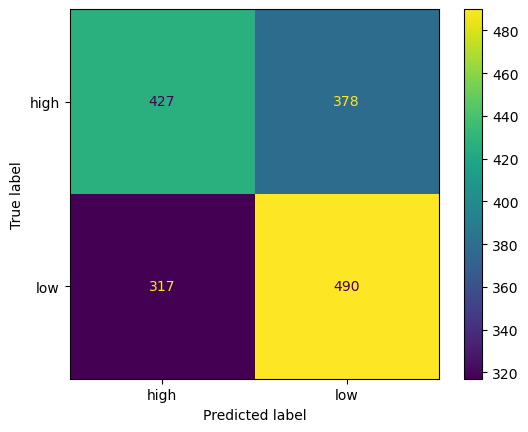

In [2605]:
# plot the confusion matrix
plot_confusion_matrix(logreg, X_test, y_test);

In [2606]:
# print the classification report
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

        high       0.57      0.53      0.55       805
         low       0.56      0.61      0.59       807

    accuracy                           0.57      1612
   macro avg       0.57      0.57      0.57      1612
weighted avg       0.57      0.57      0.57      1612



#### Interpretation of the coefficients
Looking at the odds ratio we can see that finding a job in states from IL, to NJ in the table are increasing the odds of getting a low salary job (odds ratio > 1). Looking for a job in NJ has 2.5 times the odds of finding a low salary job. Conversely Delaware, California, New York etc. have higher odds of finding a high salary job. Delaware has 0.42 times the odds of finding a low salary job (therefore 0.58 times the odds of finding a high salary job)

In [2607]:
# Create a decision tree classifier
classifier = DecisionTreeClassifier(criterion='gini',
                                  max_depth=None, 
                                  random_state=1)

In [2608]:
# Define hyperparameters for a gridsearch
params = {'max_depth': [1,2,3,4,5,10,15,20],
    'max_features': [0.1,0.25,0.5,0.75,0.9,1]}

# instantiate the gridsearch cv model
dt_gridsearch = GridSearchCV(classifier, params, cv = 5)

In [2609]:
# fit the gridsearch
dt_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
                         'max_features': [0.1, 0.25, 0.5, 0.75, 0.9, 1]})

In [2610]:
# Find the best parameters from the gridsearch
dt_gridsearch.best_params_

{'max_depth': 10, 'max_features': 0.25}

In [2611]:
# Find thes best score from the gridsearch
dt_gridsearch.best_score_

0.5652248903963771

In [2612]:
# Extract the best model and use it to score the test set
model = dt_gridsearch.best_estimator_

model.score(X_test,y_test)

0.5614143920595533

In [2613]:
# Extract the feature importances
model.feature_importances_

pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)

,Feature,Importance
3,state_FL,0.320264
15,state_NY,0.222422
0,state_CA,0.214183
16,state_OK,0.056087
12,state_MO,0.047544
21,state_WA,0.040270
11,state_MN,0.036652
5,state_IL,0.031170
13,state_NJ,0.028873
20,state_TX,0.002535


In [2614]:
from sklearn.tree import export_graphviz
import graphviz

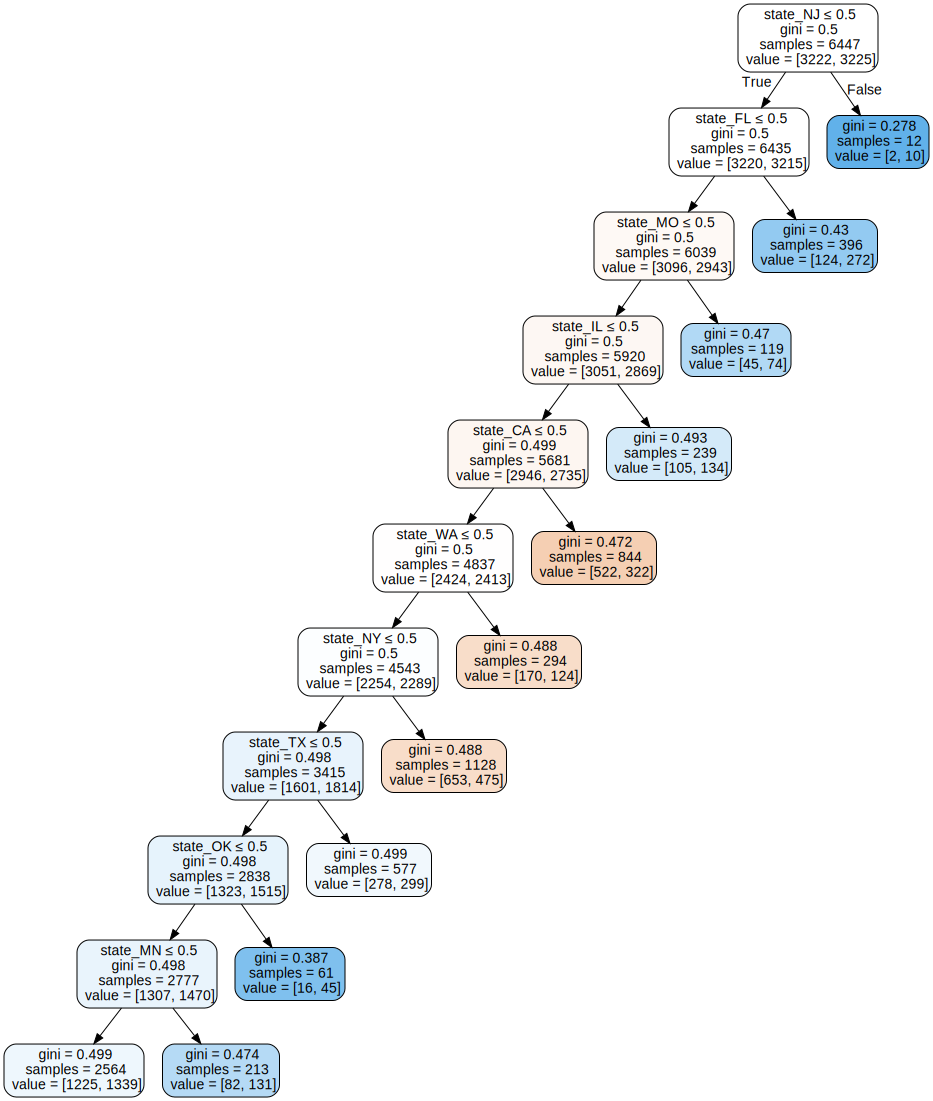

In [2615]:
# Show the decision tree
dot_data = export_graphviz(model,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=X_train.columns
                )

graph = graphviz.Source(dot_data) 

graph

### Interpretation of feature importances
The model is only using 10 states to split the data (FL with the highest importance, then NY and CA). Splitting based on only this information as predictors is clearly not going to give a very accurate model as there are 23 states with varying salary averages. We can see in the graph above that a lot of the leaves have a lot of samples from both the high and low group and it is not differentiating well. However, the accuracy was around the same as the logistic regression. We clearly need to add more features as we cannot predict accurately based on location, as all geographic regions will have a salary spread due to the job positions

### Include more features

In [2616]:
# Create a new X with more features
X = job_results[['title','state', 'remote']].copy()
X = pd.get_dummies(X, columns = ['state', 'remote'], drop_first = True)

In [2617]:
# Create a train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle = True, stratify = y, random_state=3)

In [2618]:
# make a copy of x_train and X-test so that we can reused xtrain for tfid
X_train_cvec = X_train.copy()
X_test_cvec = X_test.copy()

In [2619]:
# Instantiate and fit count vectorizer on the title column
cvec = CountVectorizer(token_pattern='\w+', stop_words = 'english')
cvec.fit(X_train_cvec['title'])

CountVectorizer(stop_words='english', token_pattern='\\w+')

In [2620]:
# Transform the x_train
X_train_title = pd.DataFrame(cvec.transform(X_train_cvec['title']).toarray(),
                  columns=cvec.get_feature_names_out())
X_train_title.head()

,0,021,02933,02nwe3,04,046868,0652u,077,1,10,...,x,xpert,xsoar,y,year,years,ykt,york,yr,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2621]:
# Transorm x_test 
X_test_title = pd.DataFrame(cvec.transform(X_test_cvec['title']).toarray(),
                  columns=cvec.get_feature_names_out())

In [2622]:
# Look at the most commonly appearing words in the training set
X_train_title.sum(axis = 0).sort_values(ascending = False).iloc[:20]

engineer       3494
senior         3144
data           1908
analyst        1799
software        792
business        680
remote          515
scientist       359
cloud           320
principal       284
systems         282
lead            250
manager         205
analytics       197
devops          186
learning        176
architect       170
machine         162
startup         133
engineering     131
dtype: int64

In [2623]:
# reset X_train index as we want to concat vectorized matrix back & this is done on index
X_train_cvec.reset_index(drop = True, inplace = True)
# drop the title column as this information is in the vectorized matrix
X_train_cvec.drop(columns = ['title'], inplace = True)

In [2624]:
# concatenate the original df and the vectorised one
X_train_cvec = pd.concat([X_train_cvec, X_train_title], axis = 1)
X_train_cvec.head()

,state_CA,state_CO,state_DE,state_FL,state_GA,state_IL,state_KS,state_LA,state_MA,state_MD,...,x,xpert,xsoar,y,year,years,ykt,york,yr,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2625]:
# repeat for test set
X_test_cvec.reset_index(drop = True, inplace = True)
X_test_cvec.drop(columns = ['title'], inplace = True)
# concat
X_test_cvec = pd.concat([X_test_cvec, X_test_title], axis = 1)
X_test_cvec.head()

,state_CA,state_CO,state_DE,state_FL,state_GA,state_IL,state_KS,state_LA,state_MA,state_MD,...,x,xpert,xsoar,y,year,years,ykt,york,yr,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2626]:
# Instantiate a logistic regression and fit to x train
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_train_cvec, y_train)

LogisticRegression(max_iter=1000)

In [2627]:
# score the logistic regression on the training data
logreg.score(X_train_cvec, y_train)

0.8357375523499302

In [2628]:
# print cross validation scores
cross_val_score(logreg, X_train_cvec, y_train)

array([0.77209302, 0.77829457, 0.78432894, 0.77967417, 0.78200155])

In [2629]:
# print mean cross val score
np.mean(cross_val_score(logreg, X_train_cvec, y_train))

0.7792784503340731

In [2630]:
# score the test set
logreg.score(X_test_cvec, y_test)

0.7723325062034739

In [2631]:
# create a gridsearch
gs_params = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-3, 0, 50)}

lr_gridsearch = GridSearchCV(logreg, gs_params, cv=5)

In [2632]:
# fit the gridsearch
lr_gridsearch.fit(X_train_cvec, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.02222996, 0.02559548, 0.02947052,
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [2633]:
# find the best score
lr_gridsearch.best_score_

0.7789687336496653

In [2634]:
# Extract the best model and use it to score the test set
lr_model = lr_gridsearch.best_estimator_

lr_model.score(X_test_cvec,y_test)

0.7710918114143921

In [2635]:
# look at the coefficients
# show a table of the logistic regression coefficients with the lowest odds ratio
lr_coefs = pd.DataFrame(lr_model.coef_, columns = X_train_cvec.columns).T
lr_coefs.columns = ['lr_coef']
lr_coefs['odds_ratio'] = np.exp(lr_coefs['lr_coef'])
lr_coefs.sort_values(by = 'lr_coef')[:10]

,lr_coef,odds_ratio
javascript,-1.930135,0.145129
vp,-1.918325,0.146853
fullstack,-1.902980,0.149124
quantitative,-1.896676,0.150067
startup,-1.882390,0.152226
director,-1.731553,0.177009
prisma,-1.693509,0.183873
lead,-1.582912,0.205376
staked,-1.579898,0.205996
ios,-1.530678,0.216389


In [2636]:
# show a table of the logistic regression coefficients with the highest odds ratio
lr_coefs.sort_values(by = 'lr_coef', ascending = False)[:10]

,lr_coef,odds_ratio
analyst,2.214231,9.154371
field,1.950887,7.034926
entry,1.842752,6.313889
junior,1.815664,6.145152
dshs,1.715269,5.558173
eligible,1.698597,5.466274
postdoctoral,1.622168,5.064055
civil,1.535922,4.645605
tia,1.432780,4.190333
saas,1.407089,4.084048


/Users/florascott/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



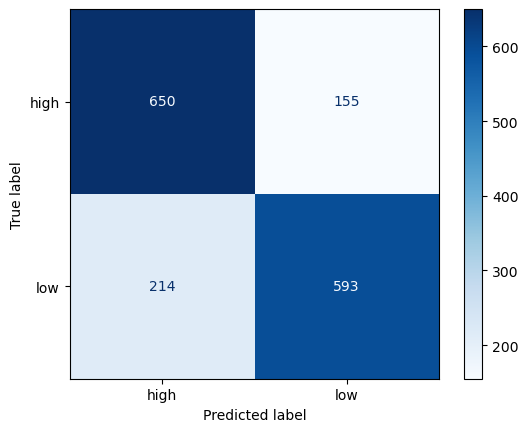

In [2637]:
# plot confusion matrix
plot_confusion_matrix(lr_model, X_test_cvec, y_test, cmap = 'Blues');

In [2638]:
# calculate y pred
y_pred = lr_model.predict(X_test_cvec)
# create a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.75      0.81      0.78       805
         low       0.79      0.73      0.76       807

    accuracy                           0.77      1612
   macro avg       0.77      0.77      0.77      1612
weighted avg       0.77      0.77      0.77      1612



### evaluation of the model
Adding the additional features has improved the accuracy score of the model. The coefficients give us insight into the words which improve the odds of a high/low salary. Unsurprisingly, 'junior' and 'entry' are increasing the odds of a low salary. 'Analyst' also appears to increase the odds of a low salary. Conversely 'vp', 'director' and 'lead' are appearing to decrease the odds of a low salary (and increase odds of high salary). Surprisingly 'startup' is also in this category - it would be interesting to look into this further as you would expect the reverse. 

Comparing the precision and recall shows that low salaries have a higher precision but lower recall than high salaries. This suggests the false positives are lower for low salaries (false negatives higher for high salaries), and it is more likely to wrongly predict high salary. 

In [2639]:
# Decision tree
# Fit the decision tree model from the last step to the new train sets
# Define hyperparameters for a gridsearch
params = {'max_depth': [1,2,3,4,5,10,20,25],
    'max_features': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]}

# instantiate the gridsearch cv model
dt_gridsearch = GridSearchCV(classifier, params, cv = 5)
# fit the gridsearch
dt_gridsearch.fit(X_train_cvec, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 20, 25],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8]})

In [2640]:
# find the best parameters
dt_gridsearch.best_params_

{'max_depth': 25, 'max_features': 0.6}

In [2641]:
# find the best cross validation score
dt_gridsearch.best_score_

0.7477930731713185

In [2642]:
# extract the best model and evaluate it on the test set
dt_model = dt_gridsearch.best_estimator_

dt_model.score(X_test_cvec, y_test)

0.7413151364764268

In [2643]:
# Extract the feature importances

pd.DataFrame(list(zip(X_train_cvec.columns, dt_model.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)[:10]

,Feature,Importance
210,analyst,0.358395
15,state_NY,0.032351
1167,lead,0.019979
23,remote_remote,0.019920
1820,senior,0.019038
1920,startup,0.017765
751,engineer,0.016836
454,cloud,0.014766
0,state_CA,0.014235
1875,software,0.012383


In [2644]:
from sklearn.ensemble import BaggingClassifier

In [2645]:
# Create a bagging classifier
dtbc = BaggingClassifier(base_estimator = DecisionTreeClassifier(), max_samples=0.4, max_features=0.6, n_estimators = 10, 
                        random_state = 0, oob_score = True)

In [2646]:
# fit the bagging classifier
dtbc.fit(X_train_cvec, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=0.6,
                  max_samples=0.4, oob_score=True, random_state=0)

In [2647]:
# Evaluate on the training set
dtbc.score(X_train_cvec, y_train)

0.8920428106095859

In [2648]:
# Evaluate on the test set
dtbc.score(X_test_cvec, y_test)

0.760545905707196

/Users/florascott/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



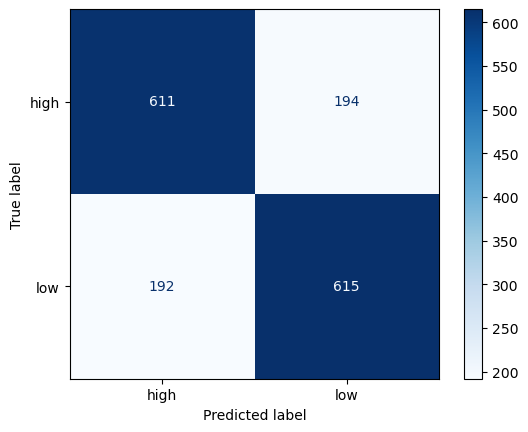

In [2649]:
# plot confusion matrix
plot_confusion_matrix(dtbc, X_test_cvec, y_test, cmap = 'Blues');

In [2650]:
# calculate y pred
y_pred = dtbc.predict(X_test_cvec)
# create a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.76      0.76      0.76       805
         low       0.76      0.76      0.76       807

    accuracy                           0.76      1612
   macro avg       0.76      0.76      0.76      1612
weighted avg       0.76      0.76      0.76      1612



### Evaluation of model
Looking at the decision tree/ bagging classifier, we can also see an improvement by adding the additional features to this model. The accuracy scores are a bit lower than for logistic regression, but comparable. Looking at the feature importances we can see the features which are most important for splitting the nodes and maximising gain. Some of these are comparable to the largest coefficients seen earlier e.g. 'lead', 'senior', 'startup', 'analyst'. This time the states NY and CA also have high feature importances. This is logical as there is a large number of samples for both and they have high average salaries. Interesting jobs marked as 'remote' are also of high feature importance

In [2651]:
# change vectorised model to tfid

# Create new copy of Xtrain and xtest
X_train_tvec = X_train.copy()
X_test_tvec = X_test.copy()

In [2652]:
# Instantiate the tfid and fit to the title column
tvec = TfidfVectorizer(stop_words = 'english')
tvec.fit(X_train_tvec['title'])

TfidfVectorizer(stop_words='english')

In [2653]:
# transform the training set
X_train_title_t = pd.DataFrame(tvec.transform(X_train_tvec['title']).toarray(),
                  columns=tvec.get_feature_names_out())
X_train_title_t.head()

,021,02933,02nwe3,04,046868,0652u,077,10,100,1006,...,writer,wuit,xpert,xsoar,year,years,ykt,york,yr,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2654]:
# Find the most commonly used words
X_train_title_t.sum(axis = 0).sort_values(ascending = False).iloc[:20]

engineer          792.885360
senior            732.015718
data              675.718091
analyst           562.138673
software          362.377421
business          315.226007
remote            201.635075
scientist         200.284415
cloud             153.906793
systems           129.418759
lead              117.129212
devops            109.620976
principal         106.512373
analytics          86.536636
learning           85.612693
manager            85.447497
machine            82.700329
architect          79.381819
network            72.231725
infrastructure     67.461970
dtype: float64

In [2655]:
# transform the test set
X_test_title_t = pd.DataFrame(tvec.transform(X_test_tvec['title']).toarray(),
                  columns=tvec.get_feature_names_out())

In [2656]:
# reset X_train index as we want to concat vectorized matrix back & this is done on index
X_train_tvec.reset_index(drop = True, inplace = True)
# drop the title column as this information is in the matrix
X_train_tvec.drop(columns = ['title'], inplace = True)

In [2657]:
# concatenate the original df and the vectorised one
X_train_tvec = pd.concat([X_train_tvec, X_train_title_t], axis = 1)
X_train_tvec.head()

/Users/florascott/opt/anaconda3/lib/python3.9/site-packages/IPython/core/displayhook.py:275: UserWarning:

Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.



,state_CA,state_CO,state_DE,state_FL,state_GA,state_IL,state_KS,state_LA,state_MA,state_MD,...,writer,wuit,xpert,xsoar,year,years,ykt,york,yr,zone
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2658]:
# reset X_train index as we want to concat vectorized matrix back & this is done on index
X_test_tvec.reset_index(drop = True, inplace = True)
# drop the title column as this information is in the matrix
X_test_tvec.drop(columns = ['title'], inplace = True)

In [2659]:
# concatenate the original df and the vectorised one
X_test_tvec = pd.concat([X_test_tvec, X_test_title_t], axis = 1)
X_test_tvec.head()

,state_CA,state_CO,state_DE,state_FL,state_GA,state_IL,state_KS,state_LA,state_MA,state_MD,...,writer,wuit,xpert,xsoar,year,years,ykt,york,yr,zone
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2660]:
# fit a logistic regression
logreg.fit(X_train_tvec, y_train)

LogisticRegression(max_iter=1000)

In [2661]:
# score the logistic regression on the training set
logreg.score(X_train_tvec, y_train)

0.8236389018147976

In [2662]:
# Score the logistic regression on the test set
logreg.score(X_test_tvec, y_test)

0.7686104218362283

/Users/florascott/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



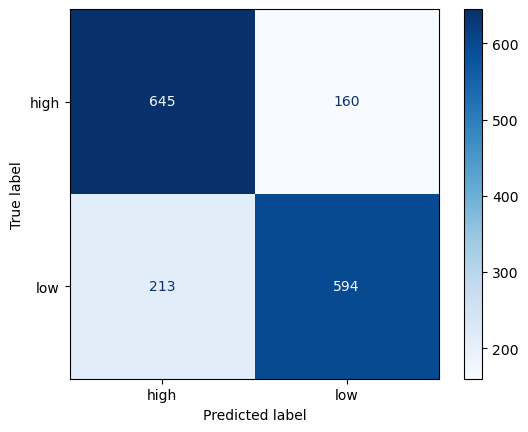

In [2663]:
# plot confusion matrix
plot_confusion_matrix(logreg, X_test_tvec, y_test, cmap = 'Blues');

In [2664]:
# calculate y pred
y_pred = logreg.predict(X_test_tvec)
# create a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.75      0.80      0.78       805
         low       0.79      0.74      0.76       807

    accuracy                           0.77      1612
   macro avg       0.77      0.77      0.77      1612
weighted avg       0.77      0.77      0.77      1612



### TFID evaluation
Tfid does not improve the model compared to a countvectorizer. This makes sense as the model is penalizing rare words. However, in this instance more common words such as 'senior' and 'lead' are having the biggest impact on predicting high vs low salary

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [2509]:
from sklearn.metrics import f1_score, precision_score, recall_score, r2_score, confusion_matrix,roc_curve, RocCurveDisplay, auc, precision_recall_curve

In [2480]:
# in order to increase the likelihood of predicting low salary, we want to change the threshold in our log regression

In [2481]:
# define a function which will return y based on probabilities and applied thresholds
def to_labels(probabilities, threshold):
    return (probabilities >= threshold).astype('int')

In [2482]:
# predict probabilities from logistic regression
prob = pd.DataFrame(lr_model.predict_proba(X_test_cvec))
prob.head()

,0,1
0,0.884092,0.115908
1,0.041391,0.958609
2,0.658340,0.341660
3,0.408304,0.591696
4,0.589501,0.410499


In [2483]:
# confirm that 0 is high and 1 low
lr_model.predict(X_test_cvec)

array(['high', 'low', 'high', ..., 'low', 'high', 'low'], dtype=object)

In [2484]:
# change high to 0 and low to 1 so that it aligns with the function above 
# (ideally should have started with these labels)
mapping = {'high':0,'low':1}
y_test_new = [mapping[i] for i in y_test]
y_test_new = np.array(y_test_new)

In [2485]:
# confirm that this has worked
y_test_new

array([0, 1, 1, ..., 1, 1, 1])

In [2486]:
# keep probabilities for the positive outcome only
prob = prob.iloc[:, 1:]
prob.head()

,1
0,0.115908
1,0.958609
2,0.341660
3,0.591696
4,0.410499


In [2487]:
# define thresholds
thresholds = range(0, 10)
thresholds = [x/10 for x in thresholds]
thresholds

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [2488]:
# predict the labels for each set of thresholds
labels = [to_labels(prob, t) for t in thresholds]
# display for threshold = 0.4
labels[4].head()

,1
0,0
1,1
2,0
3,1
4,1


In [2489]:
# evaluate each threshold using f1 score
f1_scores = [f1_score(y_test_new, to_labels(prob, t)) for t in thresholds]
f1_scores

[0.6672178586192642,
 0.7144790257104197,
 0.7540660423854116,
 0.7661851257356876,
 0.7649823736780259,
 0.7627009646302252,
 0.7465564738292011,
 0.7071905114899926,
 0.6283400809716599,
 0.4796296296296297]

In [2491]:
# evaluate each threshold using precision
precision = [precision_score(y_test_new, to_labels(prob, t)) for t in thresholds]
precision

[0.500620347394541,
 0.5617021276595745,
 0.6260229132569558,
 0.6741996233521658,
 0.7273743016759776,
 0.7927807486631016,
 0.8403100775193798,
 0.8800738007380073,
 0.9065420560747663,
 0.9487179487179487]

In [2492]:
# evaluate each threshold using recall
recall = [recall_score(y_test_new, to_labels(prob, t)) for t in thresholds]
recall

[1.0,
 0.9814126394052045,
 0.9479553903345725,
 0.8872366790582404,
 0.8066914498141264,
 0.734820322180917,
 0.6716232961586122,
 0.5910780669144982,
 0.48079306071871125,
 0.32094175960346966]

### comment
we can see that increasing the threshold of predicting low salary increases the precision. This is because at a higher threshold, the number of times low salary is predicted is decreasing, meaning the false positives decrease, and the false negatives increase. This increases the precision and decreases the recall. Conversely lowering the threshold, increases the recall and decreases the precision. We want to increase the ture and false positives for low salary (e.g. when the model makes mistakes it is more often incorrectly predicting low salary than high). Therefore we want to choose a lower threshold. Based on increasing the bias to low salary but still keeping the f1 score high, we will go with threshold = 0.4

In [2497]:
# look at the predicitons of y with a threshold of 0.4
y_pred = labels[4]
y_pred

,1
0,0
1,1
2,0
3,1
4,1
...,...
1607,0
1608,0
1609,1
1610,0


In [2287]:
# plot confusion matrix
confusion_matrix(y_test, y_pred)

array([[561, 244],
       [156, 651]])

In [2290]:
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       805
           1       0.73      0.81      0.76       807

    accuracy                           0.75      1612
   macro avg       0.75      0.75      0.75      1612
weighted avg       0.75      0.75      0.75      1612



In [2291]:
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve

/Users/florascott/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



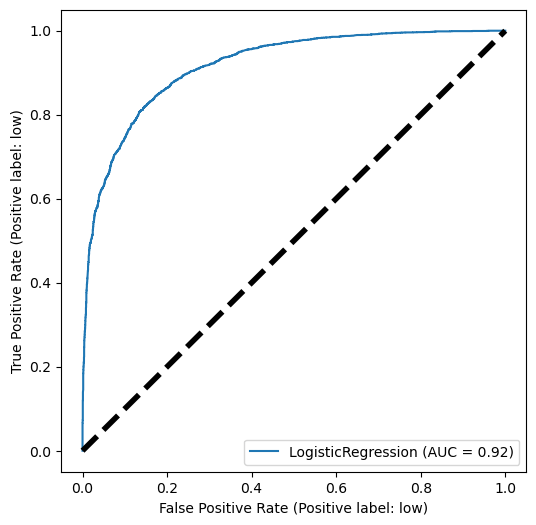

In [2505]:
# ROC curve for train set
fig, ax = plt.subplots(figsize=(6, 6))

plot_roc_curve(lr_model, X_train_cvec, y_train, ax=ax)

ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

In [2506]:
# look at auc score for train
roc_auc_score(y_train, lr_model.predict_proba(X_train_cvec)[:, 1])

0.9174150582959208

/Users/florascott/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



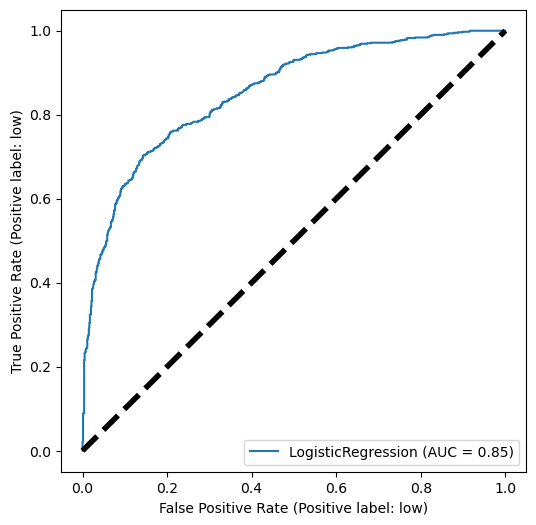

In [2507]:
# ROC curve for test set
fig, ax = plt.subplots(figsize=(6, 6))

plot_roc_curve(lr_model, X_test_cvec, y_test, ax=ax)

ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

In [2508]:
# look at auc score for train
roc_auc_score(y_test, lr_model.predict_proba(X_test_cvec)[:, 1])

0.8539395198842428

### comments on ROC
As we can see on the ROC graph as we decrease the threshold (moving from left to right along the graph), the true positive rate (sensitivity) is increasing. As the threshold decreases, we are also increasing the false positive rate (samples incorrectly predicted as low salary). Increasing the false positive rate means you are decreasing the true  negative rate (specificity). Normally, we are aiming to maximise true positive rate, and minimise false positive rate, giving us the highest sensitivity and specificity. By reducing the threshold, although we are increasing the sensitivity of the model, we are also reducing the specificity, as our false positive rate is increasing. This is the tradeoff when modifiying the model to favour low salaries.

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [16]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

**Description of data collection and model evaluation**
In order to create a model for predicting high vs low salaries,  data was scraped from the American version of indeed.com. A range of American cities and data related job titles were searched and the job title, company, job location and salary were extracted. Due to the inconsistency of how the location was written (e.g. could be town, suburb, city or state etc.), the state was extracted and used to create an initial model to predict whether a job listing was low salary (defined as below the median salary of all scraped jobs) or high salary (above the median). The confusion matrix and classification report from this model showed that the model was not particularly good at predicting either high or low salaries. The accuracy of 0.57 is not significantly higher than if we always predicted one class (e.g. low salary), as this would give us an accuracy of 0.5 due to the 50/50 distribution of the classes in the data. From the confusion matrix we can see the false positives for both classes are almost as high as the true positives, again showing that the model is predicting the wrong label almost as often as the right one. This result was unsurprising when creating a model purely on the location. Although some states may have tendencies towards higher salaries due to better economies, more opportunities etc., there will still be a distribution in salary due to the job position. For example an entry level job in California will not be paid the same as a director.  

Next, additional features were incorporated into the model. This included whether the job was remote or not (making the assumption that unless stated explicitly, it was not) as well as the job title. NLP was used to create a count vectoriser of the title, meaning the appearances of words were counted across job titles. Fitting a model using these features yielded some interesting results. In the logistic regression model, we could see that words such as ‘vp’, ‘lead’ and ‘director’ increased the odds of predicting a high salary. Interestingly ‘startup’ was also in this category as well as more specific technical skills such as ‘javascript’ and ‘fullstack’. The words that increased the odds of a low salary included ‘entry’, ‘junior’, ’postdoctoral’ and ‘analyst’. In the decision tree model we could see the features that were most often used to group samples included the words ‘analyst’, ‘lead’, ‘senior’ and ‘startup’, as well as the states of NY and CA and whether a job was remote. Incorporating these additional features significantly improved the performance of these models. Looking at the precision and recall scores for the logistic regression model, we can see that these have improved to around the 0.7-0.8 mark. The higher recall and lower precision values for the high salary group, shows us that the model is favouring a prediction of high salary, and more predicting this class more than low salary.

**Adjusting the model to favour lower salaries**
In order to increase the chances of predicting lower, rather than high salaries, the threshhold was adjusted. This means that instead of the default value of 0.5, probabilities of 0.4 and above were classes as low salary. There is a tradeoff to changing this threshhold, as discussed above. We are increasing the false positive rate, which also decreases the specificity. This means that the true negative of the high salary group is decreasing, and the model is increasing the samples where it wrongly classifies high salary as low salary. 

**Further work/ improvements on the current model**
It would be interesting to incorporate details on the company into the model. It seems unlikely that the name of the company scraped would have any impact. However,  indeed does contain features about companies which could be scraped and incorporated such as: company size, company rating, industry of the company and revenue.
A limitation of the created model is that some of the salaries used for predictions were averaged from a range, which was quite broad in some cases. It would be interesting to compare the effect of precise salaries vs ranges and see how much influence this is having.

With more time to clean the data, it may have been preferential to use more precise location tags than state. For example, although on average, NY is one of the highest salary states, there is a notable difference between Manhattan and more surburban towns. Perhaps we could have selected a certain list of cities, or grouped them by size somehow.  
Again, with more time the titles could have been cleaned a lot better. In a few cases, there is an overlap between the title and some of the other features, e.g. occasionally the title will include the state code, or whether it is a remote job. Therefore we are overlapping the information with some of these columns.
It would be interesting to spend more time looking more specifically into the NLP used on job titles. Which technical skills are associated with the highest salary and which with the lowest? Just comparing specific roles such as data analyst vs data engineer etc.
Finally, it could be of use to compare how how monthly salaries scale vs annual salaries and how the predictions of monthly salaries compares. 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [18]:
## YOUR LINK HERE IN MARKDOWN FORMAT 